In [1]:
from glob import glob
from math import floor, log10, ceil
from rasterio.features import rasterize
from rasterio.transform import from_origin, IDENTITY

import fiona
import numpy as np
import rasterio
import geopy.distance

In [2]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

In [3]:
# geojson_files = glob('../AlertaDengue/static/geojson/*')

# vitoria/es
geojson_files = ['../AlertaDengue/static/geojson/3205309.json']

# curitiba/pr
# geojson_files = ['../AlertaDengue/static/geojson/4106902.json']

In [4]:
# convert from geojson to shapefile
with fiona.open(geojson_files[0]) as geojson_file:
    with fiona.open(
        "/tmp/test.shp", "w",
        crs=geojson_file.crs, 
        driver="ESRI Shapefile", 
        schema=geojson_file.schema.copy()
    ) as shp:
        for item in geojson_file:
            shp.write(item)

In [5]:
#shp = fiona.open('zonas_farrapos.shp')
shp = fiona.open('/tmp/test.shp')
shp.bounds

(-40.36233223691069, -20.5166001683056, -28.8359076292382, -20.2397895445961)

In [6]:
coords_1 = shp.bounds[1], shp.bounds[0]
coords_2 = shp.bounds[3], shp.bounds[0]

height = geopy.distance.vincenty(coords_1, coords_2).km

coords_2 = shp.bounds[1], shp.bounds[2]

width = geopy.distance.vincenty(coords_1, coords_2).km

print('-'*80)
print('width (km):\t', width)
print('height (km):\t', height)

--------------------------------------------------------------------------------
width (km):	 1201.9730660759446
height (km):	 30.645440401884837


In [7]:
# res = 0.000901
res_x = (shp.bounds[2] - shp.bounds[0]) / width
res_y = (shp.bounds[3] - shp.bounds[1]) / height

print(res_x, res_y)

out_shape = int(height), int(width)

print('shape:\t', out_shape)
print('-'*80)
print('res_x:\t', res_x)
print('res_y:\t', res_y)

0.009589586433332119 0.009032685452693838
shape:	 (30, 1201)
--------------------------------------------------------------------------------
res_x:	 0.009589586433332119
res_y:	 0.009032685452693838


In [8]:
# help(from_origin)

In [9]:
transform = from_origin(
    shp.bounds[0] - res_x / 2,
    shp.bounds[3] + res_y / 2, 
    res_x, res_y
)
transform

Affine(0.009589586433332119, 0.0, -40.36712703012736,
       0.0, -0.009032685452693838, -20.235273201869752)

In [10]:
rgb_values = hex_to_rgb('#ff9900')
rgb_values

(255, 153, 0)

In [11]:
shapes = [
    [(geometry['geometry'], color)]
    for k, geometry in shp.items()
    for color in rgb_values
]

In [12]:
# shapes = [(geometry['geometry'], k) for k, geometry in shp.items()]

In [13]:
dtype = rasterio.float64
nodata = np.nan

raster_args = dict(
    out_shape=out_shape,
    fill=nodata,
    transform=transform,
    dtype=dtype,
    all_touched=True
)

rasters = [rasterize(shape, **raster_args) for shape in shapes]

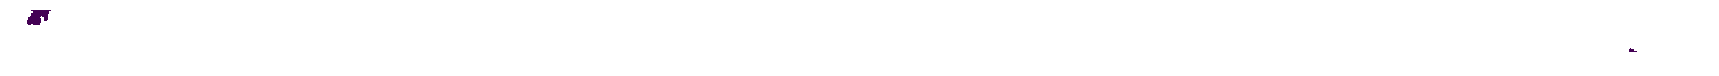

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30,10))
ax.imshow(rasters[0])
ax.axis('off');

Salvar o geotiff.

In [15]:
f_tiff_path = '/tmp/test.tiff'
with rasterio.open(
    fp=f_tiff_path, 
    mode='w',
    crs=shp.crs,
    driver='GTiff',
    # profile='GeoTIFF',
    dtype=dtype,
    count=len(rgb_values),
    width=width,
    height=height,
    nodata=nodata,
    transform=transform
    # photometric='RGB'
) as dst:
    # help(dst.write)
    for i in range(1, 4):
        print(i, rasters[i-1].shape)
        dst.write_band(i, rasters[i-1])
        # dst.write_colormap(
        #     i, {0: (255, 0, 0), 255: (0, 0, 255)}
        # )
        # print(dst.colormap(i))

1 (30, 1201)
2 (30, 1201)
3 (30, 1201)


In [16]:
import gdal

ds = gdal.Open(f_tiff_path, gdal.GA_Update)
for i in range(ds.RasterCount):
    ds.GetRasterBand(i + 1).ComputeStatistics(True)
ds = band = None  # save, close

Round-trip

In [17]:
src = rasterio.open('/tmp/test.tiff')

r, g, b = src.read()
print(src.width, src.height)
print(src.crs)
print(src.transform)
print(src.count)
print(src.indexes)
print(src.colorinterp(1))
print(src.colorinterp(2))
print(src.colorinterp(3))
# print(help(src))
print(src.nodatavals)
print(src.nodata)
print(src.read_masks().dtype)

bands = (
    ('r', r),
    ('g', g),
    ('b', b)
)

for k, band in bands:
    print('\n', k, ':')
    print('min: %s (%s)' % (np.nanmin(band), np.min(band)))
    print('max: %s (%s)' % (np.nanmax(band), np.max(band)))

1201 30
CRS({'init': 'epsg:4326'})
| 0.01, 0.00,-40.37|
| 0.00,-0.01,-20.24|
| 0.00, 0.00, 1.00|
3
(1, 2, 3)
ColorInterp.grey
ColorInterp.undefined
ColorInterp.undefined
(nan, nan, nan)
nan
uint8

 r :
min: 255.0 (nan)
max: 255.0 (nan)

 g :
min: 153.0 (nan)
max: 153.0 (nan)

 b :
min: 0.0 (nan)
max: 0.0 (nan)


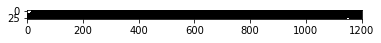

In [18]:
plt.imshow(np.dstack(src.read_masks()))
plt.show()
src.close()

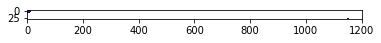

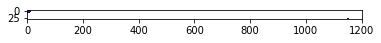

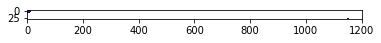

In [19]:
total = np.zeros(r.shape)
for band in r, g, b:
    plt.imshow(band)
    plt.show()
    total += band
# total /= 4

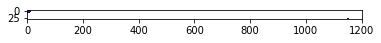

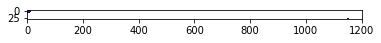

In [20]:
plt.imshow(total)
plt.show()

plt.imshow(total/3)
plt.show()

In [21]:
import pandas as pd
pd.DataFrame(total/3)

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
0,NaN,NaN,NaN,136.0,136.0,136.0,136.0,136.0,136.0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,136.0,136.0,136.0,136.0,136.0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,136.0,136.0,136.0,136.0,136.0,136.0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,136.0,136.0,136.0,136.0,136.0,136.0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,136.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Refs

http://nbviewer.jupyter.org/gist/ocefpaf/53e5be14d58c1b946952a7293f2005cf

https://github.com/mapbox/rasterio/blob/6b02fd304d10995cff818729abe47f28bd7a33b5/examples/rasterize_geometry.py

http://docs.qgis.org/2.0/es/docs/gentle_gis_introduction/raster_data.html